In [158]:
### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Data management libraries
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
import sklearn.mixture as mixture
from scipy import linalg
import math

# Other
from mltools import unsupervised_tools as UT
import joblib

# Cargar modelos de PCA, GMM y scaler
pca = joblib.load('pca_model.pkl')
gmm = joblib.load('gmm_model.pkl')
scaler = joblib.load('scaler_model.pkl')
PLSR_ll = joblib.load('PLSR_fit_ll_Galicia.pkl') # Cambiar esto en el futuro en funcion de ccaa
PLSR_nll = joblib.load('PLSR_fit_nll_Galicia.pkl') # Cambiar esto en el futuro en funcion de ccaa

# Cargar datos de prueba y nos quedamos con ccaa = Galicia, date = 2023-01-01 hasta 2023-12-31
data = pd.read_csv('eolica.csv', index_col=0)
data = data[(data['date'] >= '2023-01-01') & (data['date'] <= '2023-12-31')]
data = data[data['ccaa'] == 'Galicia']
data = data.drop(columns=['ccaa'])
n_dias = data.shape[0]
gen = data['gen']

# Seleccionar solo las columnas que fueron usadas durante el entrenamiento
numeric_inputs = ['Tmax','Tmin','Tmed','Rmed','Vmax','Pmed_00_24','Pmed_00_06','Pmed_06_12', 'Pmed_12_18','Pmed_18_24']
data = data[numeric_inputs]
data = data.reset_index(drop=True)

# Obtener scores de cada gausiana del gmm en base al punto, primeramente se pasa por el pca y el scaler
data_tr = scaler.transform(data)
data_tr = pca.transform(data_tr)

# Dado un punto: 
# 1. Calcular las probabilidades de pertenencia para cada punto a cada componente del GMM
#   1.1 Obtener la probabilidad de pertenencia de cada punto a cada componente del GMM
scores_per_component = gmm.predict_proba(data_tr) * gmm.weights_

#   1.2 Escalar la probabilidad de pertenencia para que sumen 1
scores_per_component = scores_per_component / scores_per_component.sum(axis=1, keepdims=True)

# 2. Generar escenarios utilizando una distribucion uniforme ponderada por las probabilidades de pertenencia
#   2.1 Utilizar la funcion numpy.random.choice para seleccionar un componente para cada escenario
scenario_size = 1000
matrix_nsmpl_comp_day = np.empty((scenario_size, len(gmm.weights_)-1, 0))

for i in range(len(scores_per_component)): # Va iterando en cada dia
    #   2.2 La funcion numpy.random.choice estara ponderada en base a las probabilidades de pertenencia caluladas en el paso 1
    selected_components = np.random.choice(len(gmm.weights_), size=scenario_size, p=scores_per_component[i])
    
    generated_data = []
    #   2.3 Generar un escenario para cada componente seleccionado
    for component in selected_components:
            # Media y covarianza del componente seleccionado
            mean = gmm.means_[component]
            cov = gmm.covariances_[component]
            
            # Generar un punto desde la distribución gaussiana
            sample = np.random.multivariate_normal(mean, cov)
            generated_data.append(sample)
    
      # Dimensiones: 1000x5x1

    # Concatenar el vector a la matriz en la tercera dimensión
    generated_data = np.array(generated_data)
    generated_data = generated_data[:, :, np.newaxis]
    matrix_nsmpl_comp_day = np.concatenate((matrix_nsmpl_comp_day, generated_data), axis=2)

#   2.4 Hacer la transformacion inversa y el escalado inverso para obtener los valores reales de los escenarios
numeric_inputs = ['Tmax','Tmin','Tmed','Rmed','Vmax','Pmed_00_24','Pmed_00_06','Pmed_06_12', 'Pmed_12_18','Pmed_18_24']

# Inverse transform the scenarios for each day, Duda: como hacer un dataframe de tres dimensiones
predictions = np.empty((n_dias, scenario_size))

for i in range(matrix_nsmpl_comp_day.shape[2]):
  x_scenarios = pca.inverse_transform(matrix_nsmpl_comp_day[:,:,i])
  print(x_scenarios.shape)
  x_scenarios = pd.DataFrame(scaler.inverse_transform(x_scenarios), columns=numeric_inputs)

  # 3. Predecir las respuestas para los nuevos escenarios usando los modelos PLSR
  y_pred_ll = np.empty((0, 1))
  y_pred_nll = np.empty((0, 1))
  
  x_escenarios_ll = x_scenarios[x_scenarios['Pmed_00_24'] >= 1]
  x_escenarios_nll = x_scenarios[x_scenarios['Pmed_00_24'] < 1]
  
  if x_escenarios_ll.shape[0] > 0:
    y_pred_ll = PLSR_ll.predict(x_escenarios_ll)

  if x_escenarios_nll.shape[0] > 0:
    y_pred_nll = PLSR_nll.predict(x_escenarios_nll)

  predictions[i] = np.concatenate((y_pred_ll, y_pred_nll), axis=0).flatten()

pred = np.empty((n_dias))

for i, row in data.iterrows():
  x = row.to_frame().T
  if x['Pmed_00_24'].values >= 1:
    pred[i] = PLSR_ll.predict(x)
  else:
    pred[i] = PLSR_nll.predict(x)

predictions = np.vstack((pred, predictions.T)).T


(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)

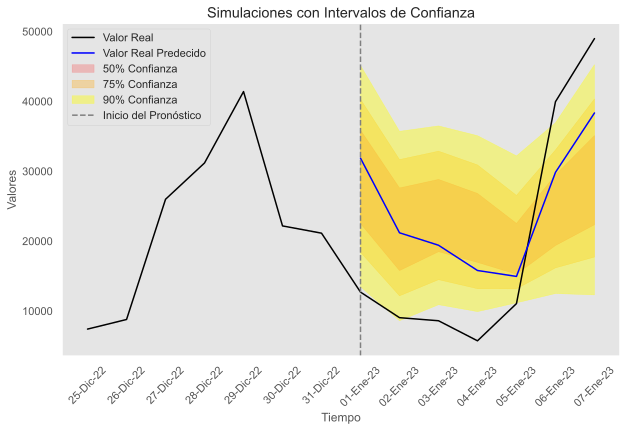

In [167]:
# Año anterior
data = pd.read_csv('eolica.csv', index_col=0)
data = data[(data['date'] >= '2022-12-25') & (data['date'] <= '2023-01-07')]
data = data[data['ccaa'] == 'Galicia']
data = data.drop(columns=['ccaa'])
gen = data['gen']

# Separar los datos: primera columna es el valor real, el resto son simulaciones
valores_reales = gen.values
simulaciones = predictions[:7, 1:]
valor_real_predecido = predictions[:7, 0]

x_1 = np.arange(len(valores_reales))  # Eje x para los 14 puntos
x_2 = np.arange(7, len(valores_reales))  # Eje x para los valores predecidos desde el 1 de enero incluido

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Calcular percentiles para los intervalos de confianza
percentiles_50 = np.percentile(simulaciones, [25, 75], axis=1)
percentiles_75 = np.percentile(simulaciones, [12.5, 87.5], axis=1)
percentiles_90 = np.percentile(simulaciones, [5, 95], axis=1)

# Dibujar los valores reales
plt.plot(x_1, valores_reales, color='black', label="Valor Real")

# Dibujar el valor real predecido
plt.plot(x_2, valor_real_predecido, color='blue', label="Valor Real Predecido")

# Dibujar las bandas de confianza
x = np.arange(len(valores_reales))  # Eje temporal
plt.fill_between(x_2, percentiles_50[0], percentiles_50[1], color='red', alpha=0.2, label="50% Confianza")
plt.fill_between(x_2, percentiles_75[0], percentiles_75[1], color='orange', alpha=0.3, label="75% Confianza")
plt.fill_between(x_2, percentiles_90[0], percentiles_90[1], color='yellow', alpha=0.4, label="90% Confianza")

# Configurar el gráfico
plt.axvline(x= len(valores_reales)//2, color='gray', linestyle='--', label="Inicio del Pronóstico")  # Línea divisoria opcional
plt.title("Simulaciones con Intervalos de Confianza")
plt.xlabel("Tiempo")
plt.ylabel("Valores")
plt.legend()
plt.grid()

# Configurar el eje x para mostrar los meses con una separación uniforme
plt.xticks(ticks=np.linspace(0, len(valores_reales) - 1, 14), labels=['25-Dic-22', '26-Dic-22', '27-Dic-22', '28-Dic-22', '29-Dic-22', '30-Dic-22', '31-Dic-22', '01-Ene-23', '02-Ene-23', '03-Ene-23', '04-Ene-23', '05-Ene-23', '06-Ene-23', '07-Ene-23'])
plt.xticks(rotation=45)
# Mostrar el gráfico
plt.show()
